# Stitching

In [ ]:
import json
import os
import pandas as pd
import numpy as np
from math import radians, cos, sin

project_folder = r"C:\Users\Yogesh Chaudhary\Desktop\ScanReg"
scans_folder = os.path.join(project_folder, "scans")
proj_file = os.path.join(project_folder, "scans.proj")


with open(proj_file, "r") as f:
    proj_data = json.load(f)

drawing_meta = proj_data["drawing"]
surface_w = int(drawing_meta["surfaceWidth"])
surface_h = int(drawing_meta["surfaceHeight"])
print(f"Reference matrix size: {surface_w} x {surface_h}")

# Example: store nominal_thk per pixel (can extend to store min/max etc.)
reference_matrix = np.full((surface_h, surface_w), np.nan)  # fill with NaN initially

def map_2d_scan_to_reference(scan_array, scan_meta, reference_matrix):
    """
    scan_array: numpy 2D array (rows x cols)
    scan_meta: dict with x, y, width, height, rotation
    reference_matrix: final reference surface (numpy array)
    """
    h_scan, w_scan = scan_array.shape
    h_ref, w_ref = reference_matrix.shape

    # Create coordinate grids
    y_idx, x_idx = np.meshgrid(np.arange(h_scan), np.arange(w_scan), indexing='ij')

    # Normalize 0-1
    x_norm = x_idx / (w_scan - 1) if w_scan > 1 else x_idx
    y_norm = y_idx / (h_scan - 1) if h_scan > 1 else y_idx

    # Scale to scan width/height
    x_scaled = x_norm * scan_meta["width"]
    y_scaled = y_norm * scan_meta["height"]

    # Rotate points around origin
    theta = np.radians(scan_meta.get("rotation", 0))
    x_rot = x_scaled * np.cos(theta) - y_scaled * np.sin(theta)
    y_rot = x_scaled * np.sin(theta) + y_scaled * np.cos(theta)

    # Translate to reference coordinates
    x_ref = np.round(x_rot + scan_meta["x"]).astype(int)
    y_ref = np.round(y_rot + scan_meta["y"]).astype(int)

    # Clip to reference bounds
    x_ref = np.clip(x_ref, 0, w_ref - 1)
    y_ref = np.clip(y_ref, 0, h_ref - 1)

    # Assign scan values into reference matrix
    reference_matrix[y_ref, x_ref] = scan_array

    return reference_matrix


def _load_csv(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns={df.columns[0]: "Distance_mm"}, inplace=True)
    df = df.replace("ND", np.nan)

    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

# Loop over all scans
for scan in proj_data["scans"]:
    scan_id = scan["id"]
    csv_path = f"{project_folder}/scans/{scan_id}.csv"
    if not os.path.exists(csv_path):
        print(f"Missing CSV: {csv_path}")
        continue
    
    df = _load_csv(csv_path)
    value_cols = df.columns[1:]  # skip Distance_mm
    scan_array = df[value_cols].values
    reference_matrix = map_2d_scan_to_reference(scan_array, scan, reference_matrix)
    print(f"Mapped scan {scan_id} into reference matrix")
    
np.save(f"{project_folder}/registered_surface.npy", reference_matrix)
print("Saved registered surface to registered_surface.npy")

# Quick visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.imshow(reference_matrix, cmap='viridis', origin='lower')
plt.colorbar(label="Nominal Thickness")
plt.show()


In [ ]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, cos, sin, ceil

# ---------------------------
# Config / Paths
# ---------------------------
proj_file = r"C:\Users\Yogesh Chaudhary\Desktop\ScanReg\Silchar AUT\Silchar AUT.h5"
project_folder = os.path.dirname(proj_file)
scans_folder = os.path.join(project_folder, "scans")


# Virtual grid resolution (mm per cell)
cell_size_mm = 50

# ---------------------------
# Load project JSON
# ---------------------------
with open(proj_file, "r") as f:
    proj_data = json.load(f)

drawing_meta = proj_data["drawing"]
surface_w_mm = drawing_meta["surfaceWidth"]
surface_h_mm = drawing_meta["surfaceHeight"]

surface_w_virtual = int(np.ceil(surface_w_mm / cell_size_mm))
surface_h_virtual = int(np.ceil(surface_h_mm / cell_size_mm))

print(f"Virtual reference matrix size: {surface_w_virtual} x {surface_h_virtual}")

# Initialize virtual reference matrix
reference_matrix = np.full((surface_h_virtual, surface_w_virtual), np.nan)

# ---------------------------
# Helper function: load CSV
# ---------------------------
def _load_csv(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns={df.columns[0]: "Distance_mm"}, inplace=True)
    df = df.replace("ND", np.nan)
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

# ---------------------------
# Map scan to virtual reference
# ---------------------------
def map_scan_to_reference_with_rotation(scan_array, scan_meta, reference_matrix, cell_size_mm=100):
    """
    Map scan to virtual grid using center rotation (same as Konva).
    """
    h_scan, w_scan = scan_array.shape
    h_ref, w_ref = reference_matrix.shape

    # Virtual cells occupied by the scan
    scan_w_cells = max(int(ceil(scan_meta["width"] / cell_size_mm)), 1)
    scan_h_cells = max(int(ceil(scan_meta["height"] / cell_size_mm)), 1)

    # Expand scan grid to match physical size
    repeat_h = int(np.ceil(scan_h_cells / h_scan))
    repeat_w = int(np.ceil(scan_w_cells / w_scan))

    scan_block = np.repeat(np.repeat(scan_array, repeat_h, axis=0), repeat_w, axis=1)
    scan_block = scan_block[:scan_h_cells, :scan_w_cells]

    # Grid coordinates before rotation
    y_idx, x_idx = np.meshgrid(np.arange(scan_h_cells), np.arange(scan_w_cells), indexing="ij")

    # Center in scan grid
    y_center = scan_h_cells / 2
    x_center = scan_w_cells / 2

    x_rel = x_idx - x_center
    y_rel = y_idx - y_center

    # Rotation
    theta = radians(scan_meta.get("rotation", 0))
    x_rot = x_rel * cos(theta) - y_rel * sin(theta)
    y_rot = x_rel * sin(theta) + y_rel * cos(theta)

    # Translate to global (Konva-style)
    x_base = scan_meta["x"] / cell_size_mm + x_center
    y_base = scan_meta["y"] / cell_size_mm + y_center

    x_final = np.clip(np.round(x_rot + x_base).astype(int), 0, w_ref - 1)
    y_final = np.clip(np.round(y_rot + y_base).astype(int), 0, h_ref - 1)

    # Write values to reference matrix
    for i in range(scan_h_cells):
        for j in range(scan_w_cells):
            reference_matrix[y_final[i, j], x_final[i, j]] = scan_block[i, j]

    return reference_matrix

# ---------------------------
# Process all scans
# ---------------------------
for scan in proj_data["scans"]:
    scan_id = scan["id"]
    csv_path = os.path.join(scans_folder, f"{scan_id}.csv")

    if not os.path.exists(csv_path):
        print(f"Missing CSV: {csv_path}")
        continue

    df = _load_csv(csv_path)
    scan_array = df[df.columns[1:]].values

    reference_matrix = map_scan_to_reference_with_rotation(
        scan_array, scan, reference_matrix, cell_size_mm
    )
    print(f"Mapped scan {scan_id}")

# ---------------------------
# Save NPY files
# ---------------------------
matrix_path = os.path.join(project_folder, "matrix.npy")
xvals_path = os.path.join(project_folder, "x_values.npy")
yvals_path = os.path.join(project_folder, "y_values.npy")

x_values = np.arange(reference_matrix.shape[1]) * cell_size_mm
y_values = np.arange(reference_matrix.shape[0]) * cell_size_mm

np.save(matrix_path, reference_matrix)
np.save(xvals_path, x_values)
np.save(yvals_path, y_values)

print("Saved matrix, x_values, y_values")

# ---------------------------
# Save as CSV WITH physical coordinates
# ---------------------------
csv_path = os.path.join(project_folder, "registered_surface_100mm.csv")

df_csv = pd.DataFrame(reference_matrix, index=y_values, columns=x_values)
df_csv.index.name = "y_mm"

df_csv.to_csv(csv_path)

print(f"Saved CSV with x_values and y_values → {csv_path}")

# ---------------------------
# Plot
# ---------------------------
plt.figure(figsize=(20, 6))
plt.imshow(
    reference_matrix,
    cmap="viridis",
    origin="lower",
    extent=[0, surface_w_mm, 0, surface_h_mm],
    aspect="auto",
)
plt.colorbar(label="Nominal Thickness")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title("Registered Virtual Surface (100mm Grid)")
plt.show()


In [ ]:
reference_matrix[reference_matrix != np.nan]

In [ ]:
import h5py
import json
import numpy as np
import os

output_path = os.path.join(project_folder, "project_data.h5")

with h5py.File(output_path, "w") as h5:

    # 1) Save reference matrix
    h5.create_dataset("matrix", data=reference_matrix, compression="gzip")

    # 2) Save x_values and y_values
    h5.create_dataset("x_values", data=x_values, compression="gzip")
    h5.create_dataset("y_values", data=y_values, compression="gzip")

    # 3) Save project JSON (as raw text)
    h5.create_dataset("project_json", data=json.dumps(proj_data))

    # 4) Save scan metadata list
    scans_json = json.dumps(proj_data["scans"])
    h5.create_dataset("scans", data=scans_json)

    # 5) Save settings
    settings = {
        "cell_size_mm": cell_size_mm,
        "surface_w_mm": surface_w_mm,
        "surface_h_mm": surface_h_mm,
        "virtual_w": surface_w_virtual,
        "virtual_h": surface_h_virtual
    }
    h5.create_dataset("settings", data=json.dumps(settings))

print(f"Saved all project data into one file: {output_path}")


# Registration in h5 project file

Virtual reference matrix size: 850 x 377
Mapped scan S#BJZDB
Mapped scan S#BNPHM
Mapped scan S#DJTDQ
Mapped scan S#KLQJO
Mapped scan S#LZIWX
Mapped scan S#MIDXJ
Mapped scan S#PWGBN
Mapped scan S#QSTKQ
Mapped scan S#SFFUD
Mapped scan S#UYHIH
Mapped scan S#WAIYQ
Mapped scan S#ZCWAG
Saved matrix, x_values, y_values and CSV inside project HDF5


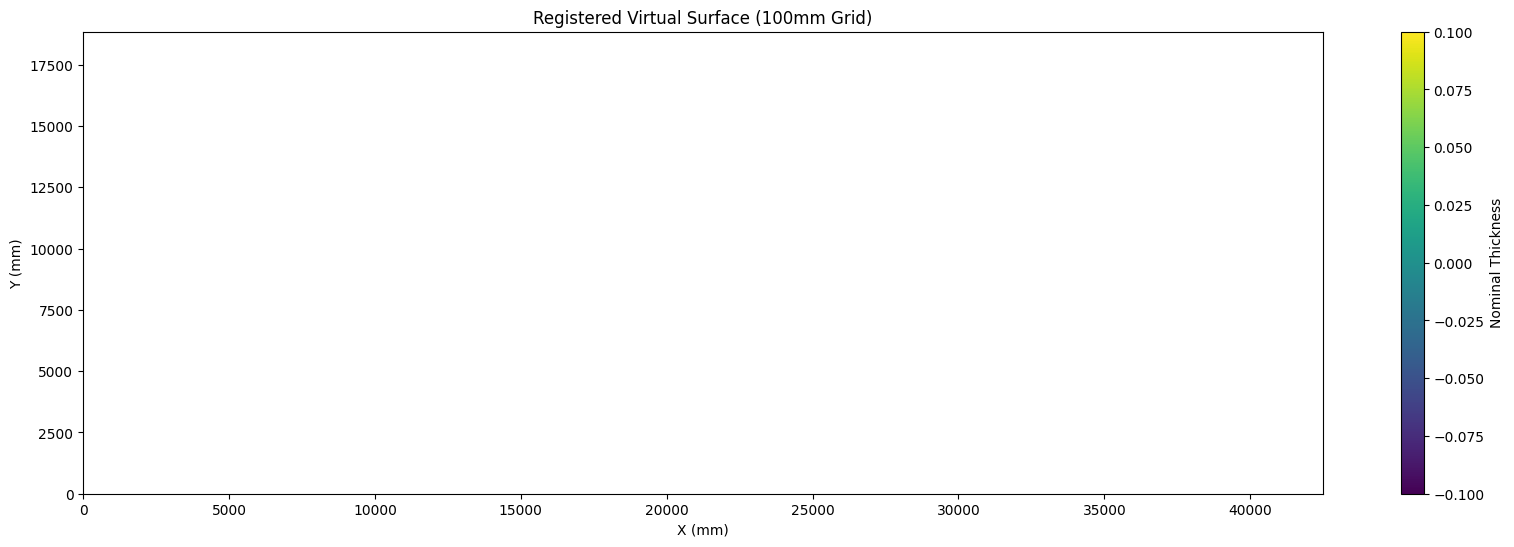

In [3]:
import os
import h5py
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, cos, sin, ceil

# ---------------------------
# Config / Paths
# ---------------------------
project_file_path = r"C:\Users\Yogesh Chaudhary\Desktop\ScanReg\Silchar AUT\Silchar AUT.h5"
scans_folder = os.path.join(os.path.dirname(project_file_path), "scans")
cell_size_mm = 50  # virtual grid resolution

# ---------------------------
# Load project metadata from HDF5
# ---------------------------
with h5py.File(project_file_path, "r") as h5:
    projectmeta = json.loads(h5["meta/project"][()].decode("utf-8"))
    drawing_meta = json.loads(h5["meta/drawing"][()].decode("utf-8"))
    scans_meta = json.loads(h5["meta/scans"][()].decode("utf-8"))

surface_w_mm = drawing_meta["surfaceWidth"]
surface_h_mm = drawing_meta["surfaceHeight"]

surface_w_virtual = int(np.ceil(surface_w_mm / cell_size_mm))
surface_h_virtual = int(np.ceil(surface_h_mm / cell_size_mm))
print(f"Virtual reference matrix size: {surface_w_virtual} x {surface_h_virtual}")

reference_matrix = np.full((surface_h_virtual, surface_w_virtual), np.nan)

# ---------------------------
# Helper: Load CSV
# ---------------------------
def _load_csv(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns={df.columns[0]: "Distance_mm"}, inplace=True)
    df = df.replace("ND", np.nan)
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

# ---------------------------
# Map scan to virtual reference (with center rotation)
# ---------------------------
def map_scan_to_reference_with_rotation(scan_array, scan_meta, reference_matrix, cell_size_mm=100):
    h_scan, w_scan = scan_array.shape
    h_ref, w_ref = reference_matrix.shape

    scan_w_cells = max(int(ceil(scan_meta["width"] / cell_size_mm)), 1)
    scan_h_cells = max(int(ceil(scan_meta["height"] / cell_size_mm)), 1)

    repeat_h = int(np.ceil(scan_h_cells / h_scan))
    repeat_w = int(np.ceil(scan_w_cells / w_scan))
    scan_block = np.repeat(np.repeat(scan_array, repeat_h, axis=0), repeat_w, axis=1)
    scan_block = scan_block[:scan_h_cells, :scan_w_cells]

    y_idx, x_idx = np.meshgrid(np.arange(scan_h_cells), np.arange(scan_w_cells), indexing="ij")
    y_center = scan_h_cells / 2
    x_center = scan_w_cells / 2

    x_rel = x_idx - x_center
    y_rel = y_idx - y_center

    theta = radians(scan_meta.get("rotation", 0))
    x_rot = x_rel * cos(theta) - y_rel * sin(theta)
    y_rot = x_rel * sin(theta) + y_rel * cos(theta)

    x_base = scan_meta["x"] / cell_size_mm + x_center
    y_base = scan_meta["y"] / cell_size_mm + y_center

    x_final = np.clip(np.round(x_rot + x_base).astype(int), 0, w_ref - 1)
    y_final = np.clip(np.round(y_rot + y_base).astype(int), 0, h_ref - 1)

    for i in range(scan_h_cells):
        for j in range(scan_w_cells):
            reference_matrix[y_final[i, j], x_final[i, j]] = scan_block[i, j]

    return reference_matrix

# ---------------------------
# Process all scans
# ---------------------------
for scan in scans_meta:
    scan_id = scan["id"]
    csv_path = os.path.join(scans_folder, f"{scan_id}.csv")
    if not os.path.exists(csv_path):
        print(f"Missing CSV: {csv_path}")
        continue

    df = _load_csv(csv_path)
    scan_array = df[df.columns[1:]].values

    reference_matrix = map_scan_to_reference_with_rotation(scan_array, scan, reference_matrix, cell_size_mm)
    print(f"Mapped scan {scan_id}")

# ---------------------------
# Prepare x/y values
# ---------------------------
x_values = np.arange(reference_matrix.shape[1]) * cell_size_mm
y_values = np.arange(reference_matrix.shape[0]) * cell_size_mm

# ---------------------------
# Save results back to HDF5 project
# ---------------------------
with h5py.File(project_file_path, "a") as h5:
    # Remove old datasets if they exist
    for key in ["output/matrix", "output/x_values", "output/y_values"]:
        if key in h5:
            del h5[key]

    h5.create_dataset("output/matrix", data=reference_matrix)
    h5.create_dataset("output/x_values", data=x_values)
    h5.create_dataset("output/y_values", data=y_values)

    # Optional: store CSV as string inside HDF5
    import io
    csv_buffer = io.StringIO()
    df_csv = pd.DataFrame(reference_matrix, index=y_values, columns=x_values)
    df_csv.index.name = "y_mm"
    df_csv.to_csv(csv_buffer)
    csv_str = csv_buffer.getvalue()
    if "output/csv" in h5:
        del h5["output/csv"]
    h5.create_dataset("output/csv", data=csv_str.encode("utf-8"))

print("Saved matrix, x_values, y_values and CSV inside project HDF5")

# ---------------------------
# Plot
# ---------------------------
plt.figure(figsize=(20, 6))
plt.imshow(
    reference_matrix,
    cmap="viridis",
    origin="lower",
    extent=[0, surface_w_mm, 0, surface_h_mm],
    aspect="auto",
)
plt.colorbar(label="Nominal Thickness")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title("Registered Virtual Surface (100mm Grid)")
plt.show()


Virtual reference matrix size: 850 x 377
Mapped scan S#BJZDB
Mapped scan S#BNPHM
Mapped scan S#DJTDQ
Mapped scan S#KLQJO
Mapped scan S#LZIWX
Mapped scan S#MIDXJ
Mapped scan S#PWGBN
Mapped scan S#QSTKQ
Mapped scan S#SFFUD
Mapped scan S#UYHIH
Mapped scan S#WAIYQ
Mapped scan S#ZCWAG
Saved registration.csv at: C:\Users\Yogesh Chaudhary\Desktop\ScanReg\Silchar AUT\registration.csv


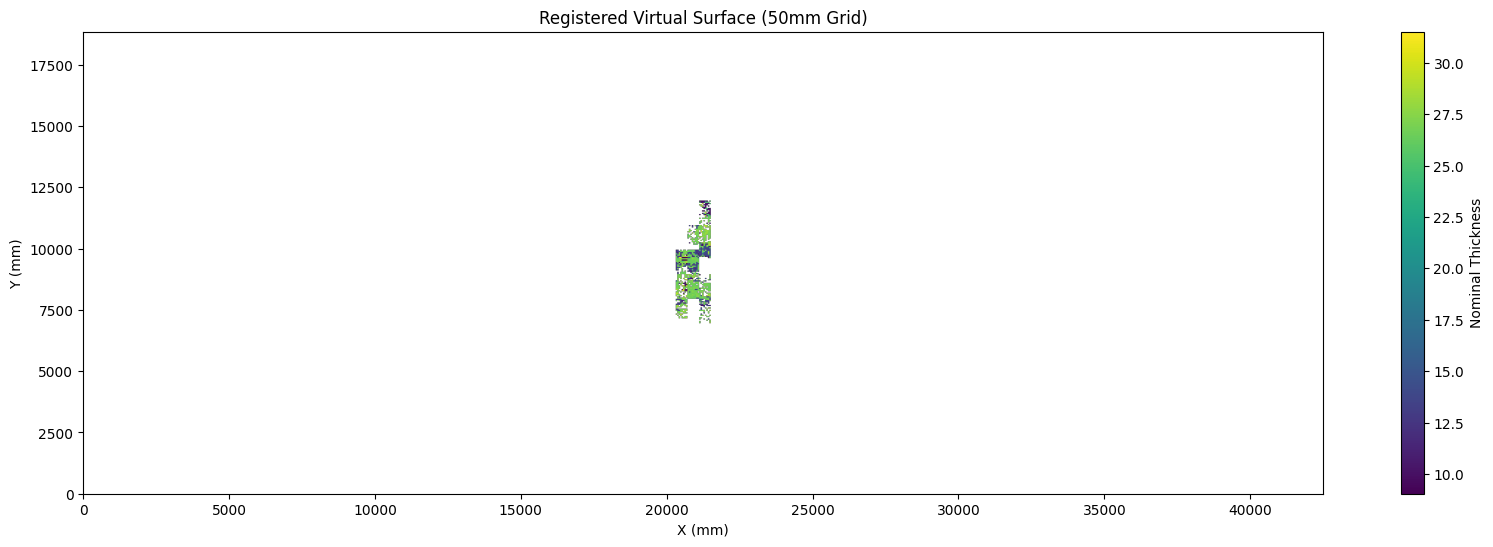

In [4]:
import os
import h5py
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, cos, sin, ceil

# ---------------------------
# Config / Paths
# ---------------------------
project_file_path = r"C:\Users\Yogesh Chaudhary\Desktop\ScanReg\Silchar AUT\Silchar AUT.h5"
scans_folder = os.path.join(os.path.dirname(project_file_path), "scans")
cell_size_mm = 50  # virtual grid resolution

# ---------------------------
# Load project metadata from HDF5
# ---------------------------
with h5py.File(project_file_path, "r") as h5:
    projectmeta = json.loads(h5["meta/project"][()].decode("utf-8"))
    drawing_meta = json.loads(h5["meta/drawing"][()].decode("utf-8"))
    scans_meta = json.loads(h5["meta/scans"][()].decode("utf-8"))

surface_w_mm = drawing_meta["surfaceWidth"]
surface_h_mm = drawing_meta["surfaceHeight"]

surface_w_virtual = int(np.ceil(surface_w_mm / cell_size_mm))
surface_h_virtual = int(np.ceil(surface_h_mm / cell_size_mm))
print(f"Virtual reference matrix size: {surface_w_virtual} x {surface_h_virtual}")

reference_matrix = np.full((surface_h_virtual, surface_w_virtual), np.nan)


# ---------------------------
# Load CSV
# ---------------------------
def _load_csv(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns={df.columns[0]: "Distance_mm"}, inplace=True)
    df = df.replace("ND", np.nan)
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df


# ---------------------------
# Improved Mapping Function
# ---------------------------
def map_scan_to_reference(scan_array, scan_meta, reference_matrix, cell_size_mm):

    h_ref, w_ref = reference_matrix.shape

    # Determine size in virtual grid cells
    scan_w_cells = int(np.ceil(scan_meta["width"] / cell_size_mm))
    scan_h_cells = int(np.ceil(scan_meta["height"] / cell_size_mm))

    # Resize scan array to virtual grid using simple nearest neighbor
    resized_scan = np.full((scan_h_cells, scan_w_cells), np.nan)
    src_h, src_w = scan_array.shape

    for y in range(scan_h_cells):
        for x in range(scan_w_cells):
            src_y = int((y / scan_h_cells) * src_h)
            src_x = int((x / scan_w_cells) * src_w)
            resized_scan[y, x] = scan_array[src_y, src_x]

    # Rotation
    theta = radians(scan_meta.get("rotation", 0))
    cy, cx = scan_h_cells / 2, scan_w_cells / 2

    y_idx, x_idx = np.meshgrid(np.arange(scan_h_cells), np.arange(scan_w_cells), indexing="ij")
    x_rel = x_idx - cx
    y_rel = y_idx - cy

    x_rot = x_rel * cos(theta) - y_rel * sin(theta)
    y_rot = x_rel * sin(theta) + y_rel * cos(theta)

    # Translation (placement in reference matrix)
    x_base = scan_meta["x"] / cell_size_mm
    y_base = scan_meta["y"] / cell_size_mm

    x_final = np.round(x_rot + x_base + cx).astype(int)
    y_final = np.round(y_rot + y_base + cy).astype(int)

    # Clip
    x_final = np.clip(x_final, 0, w_ref - 1)
    y_final = np.clip(y_final, 0, h_ref - 1)

    # Write into reference grid
    for i in range(scan_h_cells):
        for j in range(scan_w_cells):
            val = resized_scan[i, j]
            if not np.isnan(val):
                reference_matrix[y_final[i, j], x_final[i, j]] = val

    return reference_matrix


# ---------------------------
# Process all scans
# ---------------------------
for scan in scans_meta:
    scan_id = scan["id"]
    csv_path = os.path.join(scans_folder, f"{scan_id}.csv")

    if not os.path.exists(csv_path):
        print(f"Missing CSV: {csv_path}")
        continue

    df = _load_csv(csv_path)
    scan_array = df[df.columns[1:]].values

    reference_matrix = map_scan_to_reference(scan_array, scan, reference_matrix, cell_size_mm)
    print(f"Mapped scan {scan_id}")


# ---------------------------
# Prepare x/y values
# ---------------------------
x_values = np.arange(reference_matrix.shape[1]) * cell_size_mm
y_values = np.arange(reference_matrix.shape[0]) * cell_size_mm


# ---------------------------
# Save results back to HDF5
# ---------------------------
with h5py.File(project_file_path, "a") as h5:
    for key in ["output/matrix", "output/x_values", "output/y_values"]:
        if key in h5:
            del h5[key]

    h5.create_dataset("output/matrix", data=reference_matrix)
    h5.create_dataset("output/x_values", data=x_values)
    h5.create_dataset("output/y_values", data=y_values)


# ---------------------------
# NEW: Save registration.csv
# ---------------------------
registration_csv_path = os.path.join(os.path.dirname(project_file_path), "registration.csv")

df_out = pd.DataFrame(reference_matrix, index=y_values, columns=x_values)
df_out.index.name = "Y_mm"
df_out.to_csv(registration_csv_path)

print(f"Saved registration.csv at: {registration_csv_path}")


# ---------------------------
# Plot
# ---------------------------
plt.figure(figsize=(20, 6))
plt.imshow(
    reference_matrix,
    cmap="viridis",
    origin="lower",
    extent=[0, surface_w_mm, 0, surface_h_mm],
    aspect="auto",
)
plt.colorbar(label="Nominal Thickness")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title("Registered Virtual Surface (50mm Grid)")
plt.show()


# Omnipc Scan FOrmatting

In [1]:
import os
import numpy as np
import pandas as pd
import glob
import shutil
import uuid
import csv
import json

In [ ]:
import os
import csv
import glob
import json
import random
import string

folder_path = r"C:\Users\Yogesh Chaudhary\Desktop\Silchar AUT\Blisters\Scans"
output_folder = folder_path
os.makedirs(output_folder, exist_ok=True)

# -----------------------
# SMALL RANDOM ID MAKER
# -----------------------
def make_small_id():
    return "S#" + ''.join(random.choices(string.ascii_uppercase, k=5))


def process_scan_file(txt_file):
    properties = {
        "id": make_small_id(),                           # SMALL ID
        "scan_details": os.path.basename(txt_file),
        "nominal_thk": 25,
        "min_thk": None,
        "max_thk": None,
        "x": 0,
        "y": 0,
        "width": 0,
        "height": 0,
        "rotation": 0
    }

    matrix_lines = []
    metadata = {}

    with open(txt_file, "r") as f:
        for line in f:
            line = line.strip()

            if line.startswith("mm"):
                matrix_lines.append(line)
                break

            if "=" in line:
                key, value = [x.strip() for x in line.split("=", 1)]
                metadata[key] = value

        for line in f:
            matrix_lines.append(line.strip())
            
    

    # Extract metadata
    properties["min_thk"] = float(metadata.get("Min Thickness (mm)", 0))
    properties["max_thk"] = float(metadata.get("Max Thickness (mm)", 0))

    # Width & height from matrix
    header = matrix_lines[0].split("\t")[1:]
    width = len(header)
    height = len(matrix_lines) - 1

    properties["width"] = width
    properties["height"] = height

    # Save matrix CSV
    csv_filename = properties["id"] + ".csv"
    csv_filepath = os.path.join(output_folder, csv_filename)

    with open(csv_filepath, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)

        for row in matrix_lines:
            cells = row.split("\t")

            cleaned = []
            for cell in cells:
                if cell in ["ND", "---", ""]:
                    cleaned.append(None)
                else:
                    cleaned.append(cell)

            writer.writerow(cleaned)

    return properties, csv_filepath


# -------------------------
# PROCESS ALL SCAN FILES
# -------------------------

all_properties = []

for txt in glob.glob(os.path.join(folder_path, "*.txt")):
    props, csv_path = process_scan_file(txt)
    print(f"Processed → {os.path.basename(txt)} → {os.path.basename(csv_path)}")
    all_properties.append(props)


# -------------------------
# SAVE MASTER JSON
# -------------------------

# json_path = os.path.join(output_folder, "scan_properties.json")

# with open(json_path, "w") as jf:
#     json.dump(all_properties, jf, indent=4)

# print(f"\nSaved all properties JSON → {json_path}")


# -------------------------
# SAVE MASTER CSV (Properties Only)
# -------------------------

properties_csv = os.path.join(output_folder, "scan_properties.csv")

with open(properties_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    header = list(all_properties[0].keys())
    writer.writerow(header)

    for p in all_properties:
        writer.writerow([p[h] for h in header])

print(f"Saved all properties CSV → {properties_csv}")


Processed → IOCL SILCHAR MSV_131_B3_SHELL-10_(2700-3000)_G-3_r_135DEGREE_2025_02_27 12h33m30s.txt → S#ESEFS.csv
Processed → IOCL SILCHAR MSV_131_B3_SHELL-10_(3000-4000)_G-1_r_180DEGREE_2025_02_27 12h36m14s.txt → S#LSPPG.csv
Processed → IOCL SILCHAR MSV_131_B3_SHELL-10_(3000-4000)_G-2_r_180DEGREE_2025_02_27 12h39m37s.txt → S#AOMLH.csv
Processed → IOCL SILCHAR MSV_131_B3_SHELL-10_(3000-4000)_G-3_R_180DEGREE_2025_02_27 12h44m04s.txt → S#OJAFH.csv
Processed → IOCL SILCHAR MSV_131_B3_SHELL-10_(4000-4900)_G-3_r_180DEGREE_2025_02_27 12h46m08s.txt → S#XJKLO.csv
Processed → IOCL SILCHAR MSV_131_B3_SHELL-10_(4000-4940)_G-1_r_180DEGREE_2025_02_27 12h48m30s.txt → S#KKASK.csv
Processed → IOCL SILCHAR MSV_131_B3_SHELL-10_(4000-5000)_G-2_r_180DEGREE_2025_02_27 12h50m46s.txt → S#ASIUD.csv
Processed → IOCL SILCHAR MSV_131_B3_SHELL-9_(4000-5000)_G-3_r_180DEGREE_2025_12_08 12h56m32s.txt → S#INSDE.csv
Processed → IOCL SILCHAR MSV_131_B3_SHELL-9_(5000-5300)_G-3_r_180DEGREE_2025_12_08 13h13m19s.txt → S#HBTB

In [1]:
import os
import csv
import glob
import random
import string
import numpy as np
from io import StringIO

# -------------------------------------------------
# CONFIG
# -------------------------------------------------
folder_path = r"C:\Users\Yogesh Chaudhary\Desktop\Silchar AUT\cscans febr"
output_folder = folder_path
os.makedirs(output_folder, exist_ok=True)

# -------------------------------------------------
# SMALL RANDOM ID MAKER
# -------------------------------------------------
def make_small_id():
    return "S#" + ''.join(random.choices(string.ascii_uppercase, k=5))

all_properties = []

# -------------------------------------------------
# PROCESS SCAN FILES
# -------------------------------------------------
for txt_file in glob.glob(os.path.join(folder_path, "*.txt")):
    print(f"processing scan file: {txt_file}")

    properties = {
        "id": make_small_id(),
        "scan_details": os.path.basename(txt_file),
        "nominal_thk": None,
        "min_thk": None,
        "max_thk": None,
        "x": 0,
        "y": 0,
        "width": None,
        "height": None,
        "rotation": 0
    }

    matrix_lines = []
    metadata = {}

    # -----------------------
    # READ FILE
    # -----------------------
    with open(txt_file, "r") as f:
        for line in f:
            line = line.strip()

            if line.startswith("mm"):
                matrix_lines.append(line)
                break

            if "=" in line:
                key, value = [x.strip() for x in line.split("=", 1)]
                metadata[key] = value

        for line in f:
            matrix_lines.append(line.strip())

    # -----------------------
    # MATRIX PARSING (NumPy auto-coerce)
    # -----------------------
    matrix_text = "\n".join(matrix_lines)

    data = np.genfromtxt(
        StringIO(matrix_text),
        delimiter="\t",
        dtype=float,
        filling_values=np.nan
    )

    if data.ndim != 2 or data.shape[0] < 2 or data.shape[1] < 2:
        print(f"Invalid matrix in file: {txt_file}")
        continue

    # Extract axes and thickness matrix
    x_values = data[0, 1:]
    y_values = data[1:, 0]
    t_values = data[1:, 1:]

    # -----------------------
    # REVERSE MATRIX ROW-WISE
    # -----------------------
    y_values = y_values[::-1]
    t_values = t_values[::-1, :]

    # -----------------------
    # GEOMETRY
    # -----------------------
    properties["width"] = float(np.nanmax(x_values) - np.nanmin(x_values))
    properties["height"] = float(np.nanmax(y_values) - np.nanmin(y_values))

    # -----------------------
    # THICKNESS STATS
    # -----------------------
    properties["min_thk"] = float(np.nanmin(t_values))
    properties["max_thk"] = float(np.nanmax(t_values))
    properties["nominal_thk"] = float(metadata.get("Max Thickness (mm)", 0))

    # -----------------------
    # SAVE REVERSED MATRIX CSV
    # -----------------------
    csv_filename = properties["id"] + ".csv"
    csv_filepath = os.path.join(output_folder, csv_filename)

    with open(csv_filepath, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)

        # Header row
        writer.writerow(["mm"] + list(x_values))

        # Data rows (reversed)
        for y, row in zip(y_values, t_values):
            writer.writerow([y] + row.tolist())

    all_properties.append(properties)

# -------------------------------------------------
# SAVE MASTER PROPERTIES CSV
# -------------------------------------------------
properties_csv = os.path.join(output_folder, "scan_properties.csv")

if all_properties:
    with open(properties_csv, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        header = list(all_properties[0].keys())
        writer.writerow(header)
        for p in all_properties:
            writer.writerow([p[h] for h in header])

    print(f"Saved all properties CSV → {properties_csv}")
else:
    print("No valid scan files found.")


processing scan file: C:\Users\Yogesh Chaudhary\Desktop\Silchar AUT\cscans febr\IOCL SIKCHAR_MSV-131_B3_SHELL-16(2500-3000)_G3_S4 re_135DEGREE_2025_02_25 19h49m45s.txt
processing scan file: C:\Users\Yogesh Chaudhary\Desktop\Silchar AUT\cscans febr\IOCL SIKCHAR_MSV-131_B3_SHELL-16(3000-4000)_G3_S5 re_135DEGREE_2025_02_25 19h52m29s.txt
processing scan file: C:\Users\Yogesh Chaudhary\Desktop\Silchar AUT\cscans febr\IOCL SIKCHAR_MSV-131_B3_SHELL-16(4000-5000)_G3_S6 re_180DEGREE_2025_02_25 19h54m32s.txt
processing scan file: C:\Users\Yogesh Chaudhary\Desktop\Silchar AUT\cscans febr\IOCL SIKCHAR_MSV-131_B3_SHELL-16(5000-6000)_G3_S7_ re180DEGREE_2025_02_25 20h03m38s.txt
processing scan file: C:\Users\Yogesh Chaudhary\Desktop\Silchar AUT\cscans febr\IOCL SILCHAR MSV-131_B3_SHELL-03(4000-6000)_G2_S2 re_180DEGREE_2025_02_26 10h33m53s.txt
processing scan file: C:\Users\Yogesh Chaudhary\Desktop\Silchar AUT\cscans febr\IOCL SILCHAR MSV-131_B3_SHELL-03(4500-5000)_G2_S1 re_180DEGREE_2025_02_26 10h36m